In [1]:
!pip install -U torch torchtext torchaudio

!git clone https://github.com/sooftware/conformer.git
!cd conformer && pip install .

!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

     |████████████████████████████████| 881.9 MB 1.3 kB/s             
     |████████████████████████████████| 8.0 MB 50.8 MB/s            
     |████████████████████████████████| 2.9 MB 9.6 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.1
    Uninstalling torchtext-0.10.1:
      Successfully uninstalled torchtext-0.10.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
Cloning into 'conformer'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (340/340), done.
remote: Total 435 (delta 240), reused 222 (delta 95), pack-reused 0
Receiving objects: 100% (435/435), 2.88 MiB | 27.08 MiB/s, done.
Resolving

In [2]:
import os
import pickle

import torch
import librosa
import torchtext
import torchaudio
from torchaudio import transforms as T
import numpy as np 
import pandas as pd
import seaborn as sns
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence
from conformer import Conformer
from typing import Tuple
from functools import reduce
import time
from ctcdecode import CTCBeamDecoder

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
root_path = os.getcwd()
print(root_path)

torch.autograd.set_detect_anomaly(True)

/kaggle/working


In [3]:
spect_func = torchaudio.transforms.Spectrogram()

In [4]:
# class PseudoSubsampling(nn.Module):
#     def __init__(self, kernel_size):
#         self.conv = nn.Conv2d(kernel_size=kernel_size)
#         self.fc = nn.Linear(..., 31)
    
#     def forward(self, x):
#         x = self.conv(x)
#         x = nn.ReLU(x)
#         x = x.view(-1)
        
#         x = self.fc(x)
#         x = torch.nn.functional.log_softmax(x, dim=-1)
#         return x

In [5]:
class DataSubsampling(nn.Module):
    '''
    this class will downsample data
    '''
    def __init__(self, kernel_size):
        super(DataSubsampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.AvgPool2d(kernel_size=kernel_size),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequential(x)

data_subsampling = DataSubsampling(kernel_size=(2, 2))

In [6]:
def transform_audio(audio_pack):
    '''
        transform audio pack to spectrogram
    '''
    waveform, transcript = audio_pack
    spectrogram = spect_func(waveform)
    
    # (channel, feature, timestep) -> (channel, timestep, feature)
    spectrogram = spectrogram.permute(0, 2, 1)
    
    spectrogram_subsampled = data_subsampling(spectrogram)
    spectrogram_subsampled = spectrogram_subsampled.squeeze()
    
    return spectrogram_subsampled, transcript

def load_librispeech_item(fileid: str, path: str, ext_audio: str, ext_txt: str):
    speaker_id, chapter_id, utterance_id = fileid.split("-")

    file_text = speaker_id + "-" + chapter_id + ext_txt
    file_text = os.path.join(path, speaker_id, chapter_id, file_text)

    fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    file_audio = fileid_audio + ext_audio
    file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)

    # Load audio
    waveform, sample_rate = torchaudio.load(file_audio)

    # Load text
    with open(file_text) as ft:
        for line in ft:
            fileid_text, transcript = line.strip().split(" ", 1)
            if fileid_audio == fileid_text:
                break
        else:
            # Translation not found
            raise FileNotFoundError("Translation not found for " + fileid_audio)

    return transform_audio((waveform, transcript))

class LibriSpeechDataset(torch.utils.data.Dataset):
    
    _ext_txt = ".trans.txt"
    _ext_audio = ".flac"
    
    def __init__(self, data_type='train'):
        '''
            data_type \in ['train', 'dev', 'test']
        '''
        
        clean_path = '../input/librispeech-clean/LibriSpeech/'
        other_path = '../input/librispeech-500-hours/LibriSpeech/'
        
        self.list_url = [
            clean_path + 'train-clean-100',
            clean_path + 'train-clean-360',
#             other_path + 'train-other-500'
        ]
        if data_type == 'dev':
            self.list_url = [clean_path + 'dev-clean']
        elif data_type == 'test':
            self.list_url = [clean_path + 'test-clean']
        
        self._walker = []
        for path in self.list_url:
            walker = [(str(p.stem), path) for p in Path(path).glob('*/*/*' + self._ext_audio)]
            self._walker.extend(walker)
        self._walker = sorted(self._walker)
    
    def __len__(self):
        return len(self._walker)

    def __getitem__(self, n):
        fileid, path = self._walker[n]
        return load_librispeech_item(fileid, path, self._ext_audio, self._ext_txt)

In [7]:
train_set = LibriSpeechDataset('train')
dev_set = LibriSpeechDataset('dev')
test_set = LibriSpeechDataset('test')
len(train_set), len(dev_set), len(test_set)

(132553, 2703, 2620)

In [8]:
def padify(batch):
    return (
        pad_sequence([i[0] for i in batch], batch_first=True),
        [i[1] for i in batch]
    )

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, collate_fn=padify, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=batch_size, collate_fn=padify, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, collate_fn=padify, shuffle=True)

# get a sample data
it = iter(train_loader)
sample, trans = next(it)

In [9]:
alphabet = pickle.load(open("../input/librispeech-alphabet/librispeech_alphabet.pkl", "rb"))
print("Alphabet:", alphabet)

vocab = torchtext.vocab.vocab(alphabet)
vocab.insert_token('<pad>', 0) # don't have blank
vocab.insert_token('<sos>', 1)
vocab.insert_token('<eos>', 2)
default_index = -1
vocab.set_default_index(default_index)
print(vocab.get_stoi())
n_class = len(vocab)
print("n_class:", n_class)

tokens = vocab.get_itos()

def encode_string(pack):
    try:
        k = iter(pack)
    except:
        pack = (pack,)
    return [torch.LongTensor([vocab[i] for i in s]) for s in pack]

def decode_string(a):
    try:
        a = a.view(-1) # flatten
    except:
        pass
    return ''.join([vocab.lookup_token(i) for i in a if (i > 0 and i < n_class)])

Alphabet: {'M': 1, 'X': 1, 'A': 1, 'Y': 1, 'F': 1, 'D': 1, "'": 1, 'K': 1, 'S': 1, 'R': 1, 'V': 1, 'H': 1, 'B': 1, 'J': 1, 'I': 1, ' ': 1, 'O': 1, 'Z': 1, 'L': 1, 'U': 1, 'P': 1, 'N': 1, 'W': 1, 'G': 1, 'T': 1, 'E': 1, 'Q': 1, 'C': 1}
{'C': 30, 'M': 3, 'S': 11, 'E': 28, 'K': 10, 'J': 16, "'": 9, 'F': 7, 'T': 27, 'D': 8, 'Q': 29, 'Y': 6, 'V': 13, 'W': 25, ' ': 18, '<eos>': 2, 'R': 12, 'L': 21, 'P': 23, '<sos>': 1, 'U': 22, 'X': 4, '<pad>': 0, 'B': 15, 'H': 14, 'I': 17, 'O': 19, 'N': 24, 'A': 5, 'Z': 20, 'G': 26}
n_class: 31


In [10]:
def make_target(transcript, device):
    encoded = encode_string(transcript)
    target_length = torch.LongTensor([i.size(0) for i in encoded])
    target = torch.nn.utils.rnn.pad_sequence(encoded)
    return target.permute(1, 0).to(device), target_length.to(device)

In [11]:
def make_input(specs, device):
    '''
        specs: (batch, time step, feature)
    '''
    batch, time_step, _ = specs.size()
    input_length = torch.full(size=(batch,),
                             fill_value=time_step, dtype=torch.long)
    return specs.to(device), input_length.to(device)

In [12]:
def plot_spectrogram(list_spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None, ymax=None):
    fig, axs = plt.subplots(ncols=len(list_spec), figsize=(7 * len(list_spec), 5))
    for i, (spec, name) in enumerate(list_spec):
        axs[i].set_title(f'{name} Spectrogram (db)')
        axs[i].set_ylabel(ylabel)
        axs[i].set_xlabel('frame')
        im = axs[i].imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
        if xmax:
            axs[i].set_xlim((0, xmax))
        if ymax:
            axs[i].set_ylim((0, ymax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [13]:
# get sample data
k = iter(train_loader)
dat, trans = next(k)
spec, trans = train_set[0]

In [14]:
# plot_spectrogram([(spec, 'Origin'), (spec_subsampled, 'Subsampled')],
#                  xmax=spec.size(1), ymax=spec.size(0))

In [15]:
# class SpecAug(nn.Module):
#     def __init__(self,
#                  freq_mask: int = 27,
#                  time_mask_ratio: float = 0.05,
#                  n_mask: int = 10):
#         super(SpecAug, self).__init__()
#         self.freq_mask = freq_mask
#         self.time_mask_ratio = time_mask_ratio
#         self.n_mask = 10
    
#     def forward(self, x: torch.Tensor):
#         '''
#             x: (batch, timestep, feature)
#             x: (timestep, feature)
#         '''
#         time_step = x.size(0)
#         if len(x.size()) == 3:
#             time_step = x.size(1) 
#         x = T.FrequencyMasking(self.freq_mask)(x)
    
#         max_time_masking = round(self.time_mask_ratio * time_step)
        
#         time_masking = T.TimeMasking(max_time_masking)
# #         x = reduce(lambda x, y: y(x), [time_masking] * self.n_mask, x) # note lại chỗ này
#         x = time_masking(x)
#         return x

In [16]:
class ConformerCTC(nn.Module):
    def __init__(self,
#                  freq_mask: int = 27,
#                  time_mask_ratio: float = 0.05,
                 **kwargs):
        super(ConformerCTC, self).__init__()
#         self.spec_aug = SpecAug(freq_mask, time_mask_ratio)
        self.encoder = Conformer(**kwargs)
    
    def forward(self,
                inputs: torch.Tensor,
                input_length: torch.Tensor
               ) -> Tuple[torch.Tensor, torch.Tensor]:
#         inputs = self.spec_aug(inputs)
        outputs, output_lengths = self.encoder(inputs, input_length)
        return outputs, output_lengths

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Load state dict
checkpoint = torch.load('../input/conformer-ctc-model/conformer_ctc_subsampling.state')

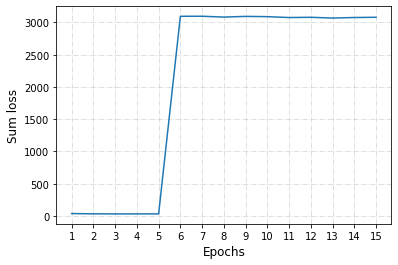

In [19]:
x = np.arange(len(checkpoint['loss_history'])) + 1
plt.plot(x, checkpoint['loss_history'])
plt.xticks(x, x)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Sum loss', fontsize=12)
plt.grid(True, alpha=0.5, ls='-.')
plt.show()

In [20]:
# Conformer size S (small)
hyp = dict(
    num_classes=n_class,
    input_dim=spec.size(-1),
    encoder_dim=144,
    num_encoder_layers=16,
    num_attention_heads=4,
    conv_kernel_size=31
)

# freq_mask=27, time_mask_ratio=0.05, 
model = ConformerCTC(**hyp).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
n_iters = 15
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), lr=0.001,
                             eps=1e-9, weight_decay=1e-6)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=n_iters)
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
cal_loss = nn.CTCLoss(zero_infinity=True).to(device)

In [22]:
# define decoder
ken_lm_path = '../input/librispeech-4gram-language-model/4-gram.arpa'

decoder = CTCBeamDecoder(
    tokens,
    model_path=ken_lm_path,
    alpha=12,
    beta=5,
    cutoff_top_n=50,
    cutoff_prob=1.0,
    beam_width=10,
    num_processes=4,
    blank_id=0,
    log_probs_input=True
)

Loading the LM will be faster if you build a binary file.
Reading ../input/librispeech-4gram-language-model/4-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [23]:
def train_epoch(model, optimizer, cal_loss, scheduler, data_loader, epoch):
    size = len(data_loader.dataset)
    model.train()
    start_time = time.perf_counter()
    sum_loss = 0
    for batch_idx, (specs, trans) in tqdm(enumerate(data_loader)):
        inputs, input_lengths = make_input(specs, device)
        targets, target_lengths = make_target(trans, device)

        optimizer.zero_grad()
        
        outputs, output_lengths = model(inputs, input_lengths)
        outputs = outputs.permute(1, 0, 2)
        
        loss = cal_loss(outputs, targets, output_lengths, target_lengths)

        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch_idx * len(specs)
        sum_loss += loss
        
        if batch_idx % 100 == 0 or current // size == 100:
            print(f"[Epoch: {epoch + 1}] = loss: {loss:>7f} [{current:>5d}/{size:>5d} ({round(current/size * 100)}%)] [{round(time.perf_counter() - start_time, 2):>6}s]")
        
    scheduler.step()
    return sum_loss

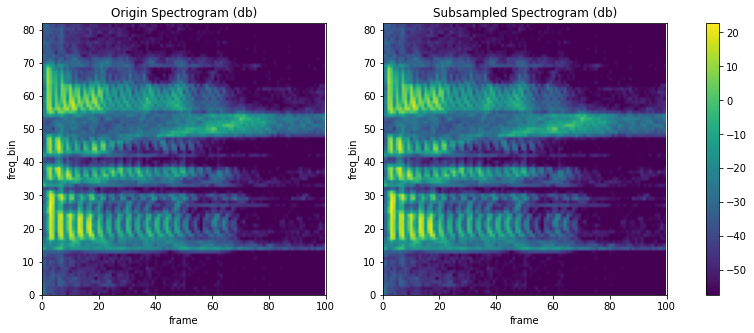

In [24]:
plot_spectrogram([(spec, 'Origin'), (spec, 'Subsampled')],
                 xmax=spec.size(1), ymax=spec.size(0))

In [25]:
cal_wer = torchaudio.functional.edit_distance

def eval_epoch(model, cal_loss, data_loader, epoch):
    size = len(data_loader.dataset)
    model.eval()
    sum_loss = 0
    sum_wer = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for batch_idx, (specs, trans) in tqdm(enumerate(data_loader)):
            inputs, input_lengths = make_input(specs, device)
            targets, target_lengths = make_target(trans, device)

            outputs, output_lengths = model(inputs, input_lengths)
            outputs = outputs.permute(1, 0, 2)
            loss = cal_loss(outputs, targets, output_lengths, target_lengths)
            
            outputs = outputs.permute(1, 0, 2)
            beam_results, beam_scores, timesteps, out_lens = decoder.decode(outputs)
            
            wer = 0
            beam_idx = 0 # default
            for idx, datum in enumerate(beam_results): # loop for each batch size
                decode_data = datum[beam_idx][:out_lens[0][0]]
                decode_result = decode_string(decode_data)
                
                wer += cal_wer(trans[idx], decode_result) / len(trans[idx]) * 100
                
            wer /= batch_size
            
            loss, current = loss.item(), batch_idx * len(specs)
            
            sum_loss += loss
            sum_wer += wer
            
            if batch_idx % 100 == 0 or current // size == 100:
                print(f"[Epoch: {epoch + 1}] | Loss: {loss:>7f} [{current:>5d}/{size:>5d} ({round(current/size * 100)}%)], Mean Wer: {wer:.2f}% [{round(time.perf_counter() - start_time, 2):>6}s]")
            
    return dict(
        loss=sum_loss / size,
        wer=sum_wer / size
    )

- Train khoảng 20 epoch đầu không validate
- Từ epoch 20 trở đi thì sẽ validate

In [26]:
loss_history = checkpoint['loss_history']
# loss_history = []
mean_wer_history = checkpoint['mean_wer_history']
# mean_wer_history = []
min_check_val = 20

start_epoch = checkpoint['epoch']
# start_epoch = -1

for it in tqdm(range(start_epoch + 1, n_iters)):
    print(f"Epoch {it} " + "-" * 30)
    loss = train_epoch(model, optimizer, cal_loss, scheduler, train_loader, it)
    loss_history.append(loss)
    
    if it == min_check_val:
        _, mean_wer = eval_epoch(model, cal_loss, dev_loader, it)
        mean_wer_history.append(mean_wer)
    
    # save each epochs
    torch.save(dict(
        epoch=it,
        model_state_dict=model.state_dict(),
        optimizer_state_dict=optimizer.state_dict(),
        scheduler_state_dict=scheduler.state_dict(),
        loss_history=loss_history,
        mean_wer_history=mean_wer_history
    ), root_path + '/conformer_ctc_subsampling.state')

0it [00:00, ?it/s]

In [27]:
eval_epoch(model, cal_loss, train_loader, 0)

0it [00:00, ?it/s]

[Epoch: 1] | Loss: 0.877130 [    0/132553 (0%)], Mean Wer: 96.02% [  1.13s]
[Epoch: 1] | Loss: 0.623616 [ 3200/132553 (2%)], Mean Wer: 98.85% [ 77.91s]
[Epoch: 1] | Loss: 1.017302 [ 6400/132553 (5%)], Mean Wer: 95.98% [147.76s]
[Epoch: 1] | Loss: 1.242463 [ 9600/132553 (7%)], Mean Wer: 95.88% [216.41s]
[Epoch: 1] | Loss: 0.887675 [12800/132553 (10%)], Mean Wer: 98.45% [283.54s]
[Epoch: 1] | Loss: 1.316156 [16000/132553 (12%)], Mean Wer: 98.63% [351.74s]
[Epoch: 1] | Loss: 0.788274 [19200/132553 (14%)], Mean Wer: 96.91% [420.07s]
[Epoch: 1] | Loss: 0.859461 [22400/132553 (17%)], Mean Wer: 98.03% [ 489.0s]
[Epoch: 1] | Loss: 0.689722 [25600/132553 (19%)], Mean Wer: 97.32% [557.04s]
[Epoch: 1] | Loss: 0.990593 [28800/132553 (22%)], Mean Wer: 98.59% [624.86s]
[Epoch: 1] | Loss: 0.465318 [32000/132553 (24%)], Mean Wer: 97.01% [693.22s]
[Epoch: 1] | Loss: 0.445197 [35200/132553 (27%)], Mean Wer: 96.89% [761.98s]
[Epoch: 1] | Loss: 0.967236 [38400/132553 (29%)], Mean Wer: 95.86% [829.55s]
[Ep

{'loss': 0.026043714021196672, 'wer': 3.033952249358126}

In [28]:
eval_epoch(model, cal_loss, dev_loader, 0)

0it [00:00, ?it/s]

[Epoch: 1] | Loss: 3.092308 [    0/ 2703 (0%)], Mean Wer: 95.87% [  0.73s]


{'loss': 0.09018402526522407, 'wer': 3.0104857709890624}

In [29]:
eval_epoch(model, cal_loss, test_loader, 0)

0it [00:00, ?it/s]

[Epoch: 1] | Loss: 3.313041 [    0/ 2620 (0%)], Mean Wer: 96.67% [   0.8s]


{'loss': 0.09212151884122659, 'wer': 3.0159620154457354}